# Strategy/Router Pattern

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from stringdale.core import get_git_root, load_env, checkLogs, json_render

load_env()

True

In [ ]:
from typing import Union,Literal,Optional
from pydantic import BaseModel,Field

from stringdale.diagrams import (
    Define,Scope,
    V,E,
    draw_diagram
)
from stringdale.chat import Chat
from stringdale.std import Condition as C

## Sub Agents

In [ ]:
rhyming_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following questions using rhyming words.
    """},
    {'role':'user','content':'{{question}}'},
    ],
    )


await rhyming_agent(question='what is the capital of france?')

{'role': 'assistant',
 'content': 'In Paris, the heart beats fast, a city of beauty, unsurpassed.',
 'meta': {'input_tokens': 129, 'output_tokens': 24}}

In [ ]:
joke_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following question with a joke.
    """},
    {'role':'user','content':'{{question}}'},
    ])

await joke_agent(question='what is the capital of france?')

{'role': 'assistant',
 'content': 'Why did the French chef get arrested? Because he was caught beating the eggs in Paris!',
 'meta': {'input_tokens': 127, 'output_tokens': 26}}

In [ ]:
yo_mama_chat = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following question with a joke about the person's mother.
    """},
    {'role':'user','content':'{{question}}'},
    ])

await yo_mama_chat(question='what is the capital of france?')

{'role': 'assistant',
 'content': 'Why did your mother go to Paris? Because she heard it was the best place to find a good "eiffel"-ing!',
 'meta': {'input_tokens': 131, 'output_tokens': 35}}

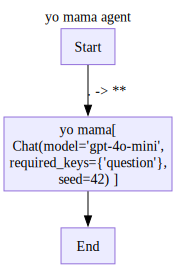

In [ ]:
with Define('yo mama agent') as YoMamaAgent:
    V('yo mama',yo_mama_chat,inputs=['Start(**)'],outputs=['End'])

In [ ]:
yo_mama_agent = YoMamaAgent()
yo_mama_agent.run_all({
    'question':'what is the capital of france?'
    })

{'role': 'assistant',
 'content': 'Why did your mother go to Paris? Because she heard it was the best place to find a good "eiffel"-ing!',
 'meta': {'input_tokens': 131, 'output_tokens': 35}}

## Strategy pattern

In [ ]:
sub_agent_dict = {
    'rhyme':rhyming_agent,
    'joke':joke_agent,
    'yo_mama':yo_mama_agent
}

In [ ]:
chooser = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Choose the best sub-agent to answer the following question.
    """},
    {'role':'user','content':'{{question}}'},
    ],
    choices=list(sub_agent_dict.keys()),
    )


In [ ]:
await chooser(question='what is the capital of france?, I like rhymes')

{'role': 'assistant',
 'content': 'rhyme',
 'meta': {'input_tokens': 158, 'output_tokens': 12}}

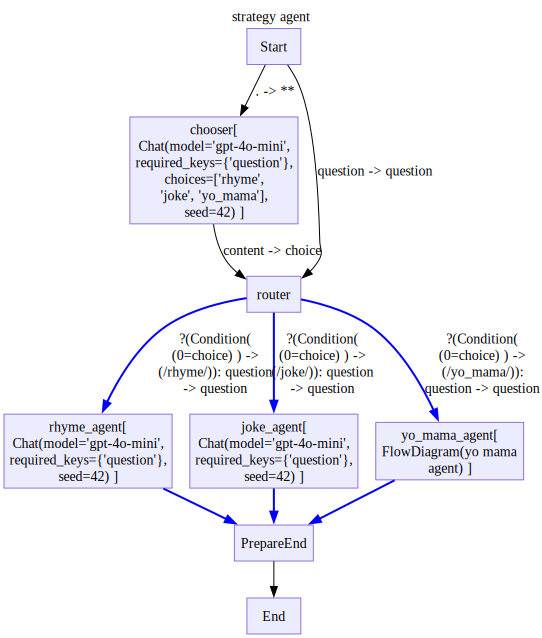

In [ ]:
with Define('strategy agent',type='decision') as StrategyAgent:
    with Scope('flow'):
        V('chooser',chooser,inputs=['Start(**)'])
        V('router',inputs=['Start(question=question)','chooser(choice=content)'])
        V('PrepareEnd',outputs=['End']) # TODO make compression work without this extra node

    for choice_code,sub_agent in sub_agent_dict.items():
        sub_agent_node_name = f'{choice_code}_agent'
        E(f'router->{sub_agent_node_name}(question=question)',cond=C(f'{choice_code}','(0=choice)'))
        V(sub_agent_node_name,sub_agent,outputs=['PrepareEnd'])
        


In [ ]:
d = StrategyAgent()
for trace in d.run({'question':"what is the capital of france?, I like yo mama jokes"}):
    trace.pprint(show_input=False,skip_passthrough=True)

Node chooser:
{ 'output': { 'content': 'yo_mama',
              'meta': {'input_tokens': 159, 'output_tokens': 12},
              'role': 'assistant'}}
Node yo_mama_agent.yo mama:
{ 'output': { 'content': "Yo mama's so lazy, she got a job at the Eiffel Tower "
                         'just so she could say she works from home!',
              'meta': {'input_tokens': 136, 'output_tokens': 32},
              'role': 'assistant'}}
Node yo_mama_agent:
{ 'output': { 'content': "Yo mama's so lazy, she got a job at the Eiffel Tower "
                         'just so she could say she works from home!',
              'meta': {'input_tokens': 136, 'output_tokens': 32},
              'role': 'assistant'}}
